In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym

import matplotlib.pyplot as plt

In [2]:
class CartPoleNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        HIDDEN_LAYER_DIMS = 30
        self.fc = nn.Sequential(
            nn.Linear(4, HIDDEN_LAYER_DIMS),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_DIMS, HIDDEN_LAYER_DIMS),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_DIMS, HIDDEN_LAYER_DIMS),
            nn.ReLU(),
            nn.Linear(HIDDEN_LAYER_DIMS, 2)
        )

    def forward(self, observation):
        return self.fc(observation)

cartpole_model = CartPoleNeuralNetwork()
target_model = CartPoleNeuralNetwork()

In [3]:
class DQN():
    def __init__(self, env : gym.Env, model : torch.nn.Module, target : torch.nn.Module, replay_memory_size, device):
        self._env = env
        
        self._model = model
        self._target = target

        self._replay_memory = torch.empty(size=(replay_memory_size, 11), dtype=torch.float32, device=device)

        self._device = device

    
    def train(self, discount_factor, optimizer, loss_fn, minibatch_size, C, g, episodes, max_time_steps, options=None, threshold=5):
        env = self._env
        epsilon = 1
        epsilon_decay_factor = np.power(0.01, np.divide(1, episodes))
        replay_index = 0
        self.__fill_replay_buffer(options)
        epsilon_values = []
        cum_reward_per_episode_values = []
        loss_values = []

        loss_per_episode_vals = []

        network_instances = []

        model_state_dict = self._model.state_dict()
        network_instance = {}
        for k, v in model_state_dict.items():
            network_instance[k] = v.tolist()
        network_instances.append(network_instance)

        self._target.load_state_dict(model_state_dict)
        for i in range(episodes):
            cum_reward = 0
            # print(f'Episode: {i+1}')
            observation, _ = env.reset(options=options)
            
            for i in range(max_time_steps):
                action = self.__select_action(epsilon, observation)
                new_observation, reward, term, _, _ = env.step(action)
                cum_reward += reward
                self.__store_transition(observation, reward, action, new_observation, term, replay_index)
                replay_index += 1

                if replay_index == self._replay_memory.shape[0]:
                    replay_index = 0

                if (i+1) % g == 0:
                    minibatch = self.__sample_minibatch(minibatch_size)
                    loss_val = self.__backpropagation(optimizer, loss_fn, discount_factor, minibatch, loss_values)

                if (i+1) % C == 0:
                    self._target.load_state_dict(self._model.state_dict())
                    
                if term: break
                
                observation = new_observation

            loss_per_episode_vals.append(loss_val)

            network_instance = {}
            state_dict = self._model.state_dict()
            for k, v in state_dict.items():
                network_instance[k] = v.tolist()

            network_instances.append(network_instance)
            
            epsilon_values.append(epsilon)
            epsilon *= epsilon_decay_factor
            cum_reward_per_episode_values.append(cum_reward)
            
            if cum_reward_per_episode_values.__len__() >= threshold:
                if np.mean(cum_reward_per_episode_values[-threshold:]) == 500: break

        network_training_metrics = {
            'network_instances': network_instances,
            'loss_values_per_episode': loss_per_episode_vals,
            'total_rewards': cum_reward_per_episode_values,
            'epsilon_values': epsilon_values
        }
            
        return loss_values, network_training_metrics


    def __backpropagation(self, optimizer, loss_fn, discount_factor, minibatch : torch.Tensor, loss_values):
        model_input = minibatch[:, :4]
        model_output = self._model(model_input)
        pred = torch.gather(model_output, 1, minibatch[:, 5].long().unsqueeze(1)).squeeze(1)

        target_input = minibatch[:, 6:10]
        target_output = self._target(target_input)
        max_qvalues = torch.max(target_output, dim=1).values
        y = minibatch[:, 4] + max_qvalues * (1 - minibatch[:, 10].to(torch.int)) * discount_factor

        optimizer.zero_grad()
        loss = loss_fn(pred, y)
        loss_val = loss.item()
        loss_values.append(loss_val)
        # torch.nn.utils.clip_grad_norm_(self._model.parameters(), 3.0)
        loss.backward()
        optimizer.step()
        
        return loss_val

        
    def __sample_minibatch(self, minibatch_size):
        indices = torch.randint(0, self._replay_memory.shape[0]-1, (minibatch_size,))
        return self._replay_memory[indices]

    
    def __fill_replay_buffer(self, options=None):
        env = self._env
        replay_mem_length = self._replay_memory.shape[0]

        observation, _ = env.reset(options=options)
        for i in range(replay_mem_length):
            action = env.action_space.sample()
            new_observation, reward, term, _, _ = env.step(action)
            self.__store_transition(observation, reward, action, new_observation, term, i)

            observation = new_observation
            
            if term:
                observation, _ = env.reset(options=options)


    def __store_transition(self, observation, reward, action, new_observation, term, index):
        self._replay_memory[index, :4] = torch.tensor(observation, device=self._device)
        self._replay_memory[index, 4] = reward
        self._replay_memory[index, 5] = action
        self._replay_memory[index, 6:10] = torch.tensor(new_observation, device=self._device)
        self._replay_memory[index, 10] = term


    def __select_action(self, epsilon, observation):
        if np.random.rand() < epsilon:
            return self._env.action_space.sample()
        else:
            observation = torch.tensor(observation, device=self._device)
            q_values = self._model(observation)
            return torch.argmax(q_values).item()

In [4]:
model = CartPoleNeuralNetwork()
target = CartPoleNeuralNetwork()

device = 'cpu'
env = gym.make('CartPole-v1')
dqn = DQN(env, model, target, 5000, device)

In [5]:
discount_factor = 0.99
minibatch_size = 256
g = 3
C = 10
episodes = 400
max_time_steps = 500
threshold = 5

optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [6]:
loss_values, network_training_metrics = dqn.train(discount_factor, optimizer, loss_fn, minibatch_size, C, g, episodes, max_time_steps, threshold=threshold)

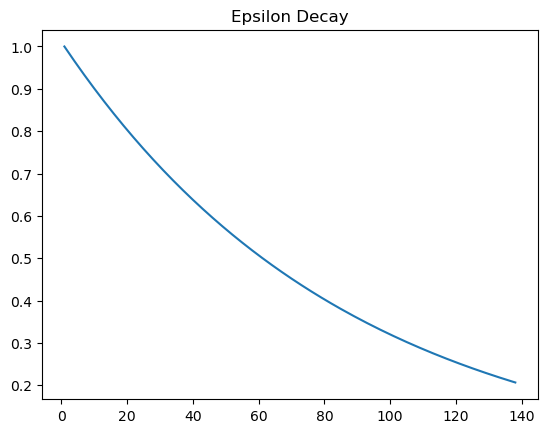

In [7]:
epsilon_values = network_training_metrics['epsilon_values']
l = len(epsilon_values)
xhi = np.linspace(1, l, l)
plt.plot(xhi, epsilon_values)
plt.title('Epsilon Decay')
plt.show()

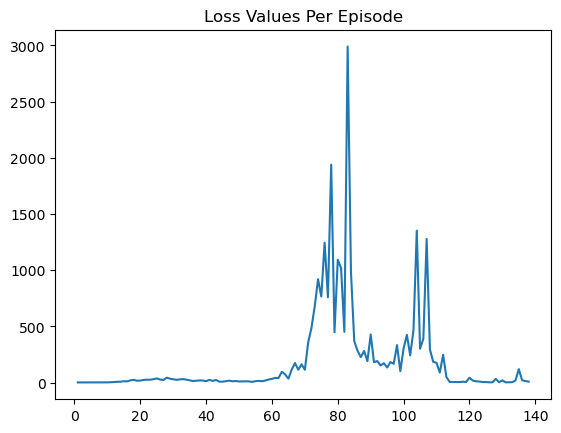

In [8]:
loss_values_per_episode = network_training_metrics['loss_values_per_episode']
l = len(loss_values_per_episode)
xhi = np.linspace(1, l, l)
plt.plot(xhi, loss_values_per_episode)
plt.title('Loss Values Per Episode')
plt.show()

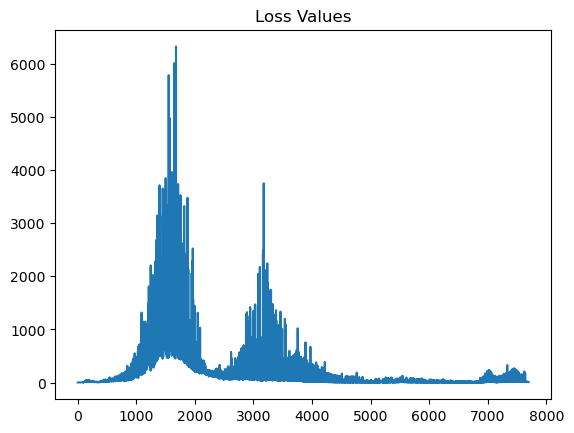

In [9]:
l = len(loss_values)
xhi = np.linspace(1, l, l)
plt.plot(xhi, loss_values)
plt.title('Loss Values')
plt.show()

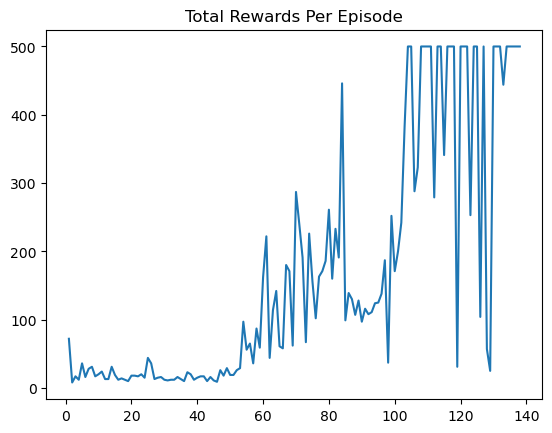

In [10]:
cum_reward_per_episode = network_training_metrics['total_rewards']
l = len(cum_reward_per_episode)
x = np.linspace(1, l, l)
plt.plot(x, cum_reward_per_episode)
plt.title('Total Rewards Per Episode')
plt.show()

In [11]:
env = gym.make('CartPole-v1')
cum_reward_per_episode = []
for _ in range(100):
    observation, _ = env.reset()
    cum_reward = 0
    for _ in range(500):
        model_input = torch.tensor(observation)
        q_values = model(model_input)
        action = torch.argmax(q_values).item()

        observation, reward, term, _, _ = env.step(action)
        cum_reward += reward

        if term: break
    cum_reward_per_episode.append(cum_reward)
env.close()

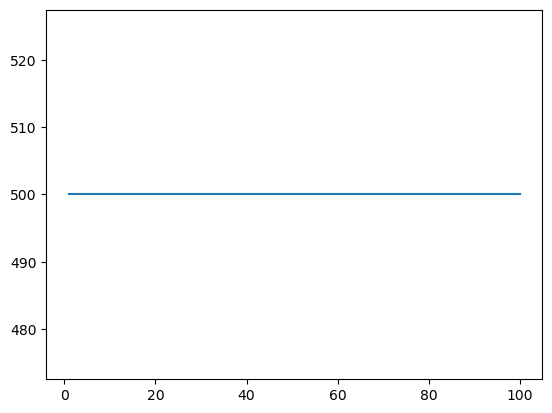

In [12]:
l = len(cum_reward_per_episode)
x = np.linspace(1, l, l)
plt.plot(x, cum_reward_per_episode)
plt.show()

In [41]:
network_instances = {}
with open('vdqn4.bin', 'rb') as f:
    network_instances = orjson.loads(f.read())

In [43]:
network_training_metrics['network_instances'] = network_instances

In [47]:
network_training_metrics.keys()

dict_keys(['network_instances', 'loss_values_per_episode', 'total_rewards', 'epsilon_values'])

In [50]:
json_bytes = orjson.dumps(network_training_metrics['loss_values_per_episode'])

In [52]:
epsilon_vals = network_training_metrics['epsilon_values']
json_serializable_epsilon = []
for ev in epsilon_vals:
    json_serializable_epsilon.append(float(ev))

In [53]:
json_bytes = orjson.dumps(json_serializable_epsilon)

In [60]:
network_training_metrics['epsilon_values'] = json_serializable_epsilon

In [61]:
json_bytes = orjson.dumps(network_training_metrics['network_instances'])
json_bytes = orjson.dumps(network_training_metrics['loss_values_per_episode'])
json_bytes = orjson.dumps(network_training_metrics['total_rewards'])
json_bytes = orjson.dumps(network_training_metrics['epsilon_values'])

In [62]:
json_bytes = orjson.dumps(network_training_metrics)

In [66]:
json_content = orjson.loads(json_bytes)

assert json_content == network_training_metrics

In [67]:
with open('cartpole_vdqn_data.bin', 'wb') as f:
    f.write(json_bytes)

In [70]:
import hashlib

hash = hashlib.sha256(json_bytes).hexdigest()
content_len = len(json_bytes)

print(hash)
print(content_len)

d173d316266f61ef64e76cb74a69df6e8129f2914d5e8f796649593f6a29b1c4
5815590
